In [82]:
import pandas as pd
from darts import TimeSeries
from darts.models.forecasting.random_forest import RandomForest
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [83]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [84]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [85]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    target_lags_list = [-i for i in range(1, 5)]
    params = {
        'n_estimators': 150,
        'max_depth': 18,
        'min_samples_split': 13,
        'min_samples_leaf': 13,
        'max_features': 0.5774519952255706,
        'bootstrap':False,
        'criterion':"squared_error",
        'min_weight_fraction_leaf': 0.0003584570012586107,
        'n_jobs': -1
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    scaler = scaler.fit(train_fold)
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    
    model = RandomForest(
        lags=target_lags_list,
        add_encoders=encoders,
        **params
    )

    model.fit(
        series=train_scaled,
        val_series=val_scaled,
    )
    
    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    20.382103    4.514654    3.516353  0.593857   
Precipitation_accumulated       0.788887    0.888193    0.411374 -0.273905   
Humidity                      268.161174   16.375627   12.825969  0.136129   
Wind_Speed_kmh                  0.638558    0.799098    0.670779 -0.531068   
Soil_Moisture              323983.493717  569.195479  363.838839  0.468457   
Soil_Temperature               25.485626    5.048329    3.923990  0.652352   
Wind_Dir_Sin                    0.251747    0.501744    0.420876  0.205297   
Wind_Dir_Cos                    0.374256    0.611764    0.509576  0.038659   

                                SMAPE  
Temperature                 21.800414  
Precipitation_accumulated   12.193277  
Humidity                    19.598890  
Wind_Speed_kmh              59.282039  
Soil_Mo

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    13.838676    3.720037    2.536614  0.601603   
Precipitation_accumulated  145732.414187  381.749151  322.784124 -2.539220   
Humidity                      467.129746   21.613185   18.557088 -2.728595   
Wind_Speed_kmh                  1.301368    1.140775    0.976296 -2.858010   
Soil_Moisture              307176.917059  554.235435  469.500562  0.800872   
Soil_Temperature               16.317943    4.039547    2.902061  0.543544   
Wind_Dir_Sin                    0.268783    0.518443    0.425234 -0.115432   
Wind_Dir_Cos                    0.570796    0.755510    0.654402  0.141433   

                                SMAPE  
Temperature                 17.977894  
Precipitation_accumulated  155.429401  
Humidity                    25.720843  
Wind_Speed_kmh             129.754432  
Soil_Mo

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE            R2  \
Temperature                   10.091889    3.176773   2.702049 -7.247381e-01   
Precipitation_accumulated      7.229275    2.688731   2.232914 -5.695979e+04   
Humidity                      18.032957    4.246523   3.531960 -5.385256e-02   
Wind_Speed_kmh                 0.004010    0.063325   0.051142          -inf   
Soil_Moisture              16018.527437  126.564321  99.101390 -1.112518e+01   
Soil_Temperature               6.104668    2.470763   2.060570  7.288669e-02   
Wind_Dir_Sin                   0.000083    0.009098   0.006377          -inf   
Wind_Dir_Cos                   0.000568    0.023838   0.020610          -inf   

                                SMAPE  
Temperature                 17.272143  
Precipitation_accumulated    0.489106  
Humidity                     4.047642  
Wind_Speed_kmh             20

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     0.807077    0.898375    0.750518 -0.372700   
Precipitation_accumulated       0.138878    0.372664    0.275013 -3.230888   
Humidity                        9.409612    3.067509    2.408863  0.015268   
Wind_Speed_kmh                  0.000015    0.003854    0.001291      -inf   
Soil_Moisture              117300.533905  342.491655  289.245554 -2.177775   
Soil_Temperature                0.080833    0.284312    0.202354  0.666495   
Wind_Dir_Sin                    0.000001    0.001064    0.000488      -inf   
Wind_Dir_Cos                    0.000003    0.001840    0.001022      -inf   

                                SMAPE  
Temperature                  7.768994  
Precipitation_accumulated    0.060022  
Humidity                     2.660276  
Wind_Speed_kmh             200.000000  
Soil_Mo

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                     7.529580    2.744008    2.035623  -2.161343   
Precipitation_accumulated       1.902423    1.379283    0.623046  -5.815188   
Humidity                       56.362683    7.507508    5.845404  -0.172615   
Wind_Speed_kmh                  0.025477    0.159616    0.056116 -11.554584   
Soil_Moisture              245736.005036  495.717667  256.111012 -30.209401   
Soil_Temperature                5.485428    2.342099    1.687764  -2.375077   
Wind_Dir_Sin                    0.013595    0.116600    0.039313   0.759677   
Wind_Dir_Cos                    0.025339    0.159182    0.051153   0.706795   

                                SMAPE  
Temperature                 26.037441  
Precipitation_accumulated    0.135930  
Humidity                     6.935718  
Wind_Speed_kmh             192.171239 

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE         R2  \
Temperature                1.329423e+01     3.646125     2.778268  -0.443993   
Precipitation_accumulated  1.874806e+01     4.329903     3.752871 -15.003273   
Humidity                   1.107078e+02    10.521779     8.514700   0.049744   
Wind_Speed_kmh             2.206373e+00     1.485387     0.966250  -0.421622   
Soil_Moisture              2.550392e+06  1596.994761  1380.244935  -0.869888   
Soil_Temperature           1.997284e+01     4.469098     3.628826  -2.972163   
Wind_Dir_Sin               6.524196e-01     0.807725     0.542947  -0.355256   
Wind_Dir_Cos               3.366320e-01     0.580200     0.461864   0.295669   

                                SMAPE  
Temperature                 54.440985  
Precipitation_accumulated    0.816584  
Humidity                     9.411885  
Wind_Speed_kmh             12

In [86]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


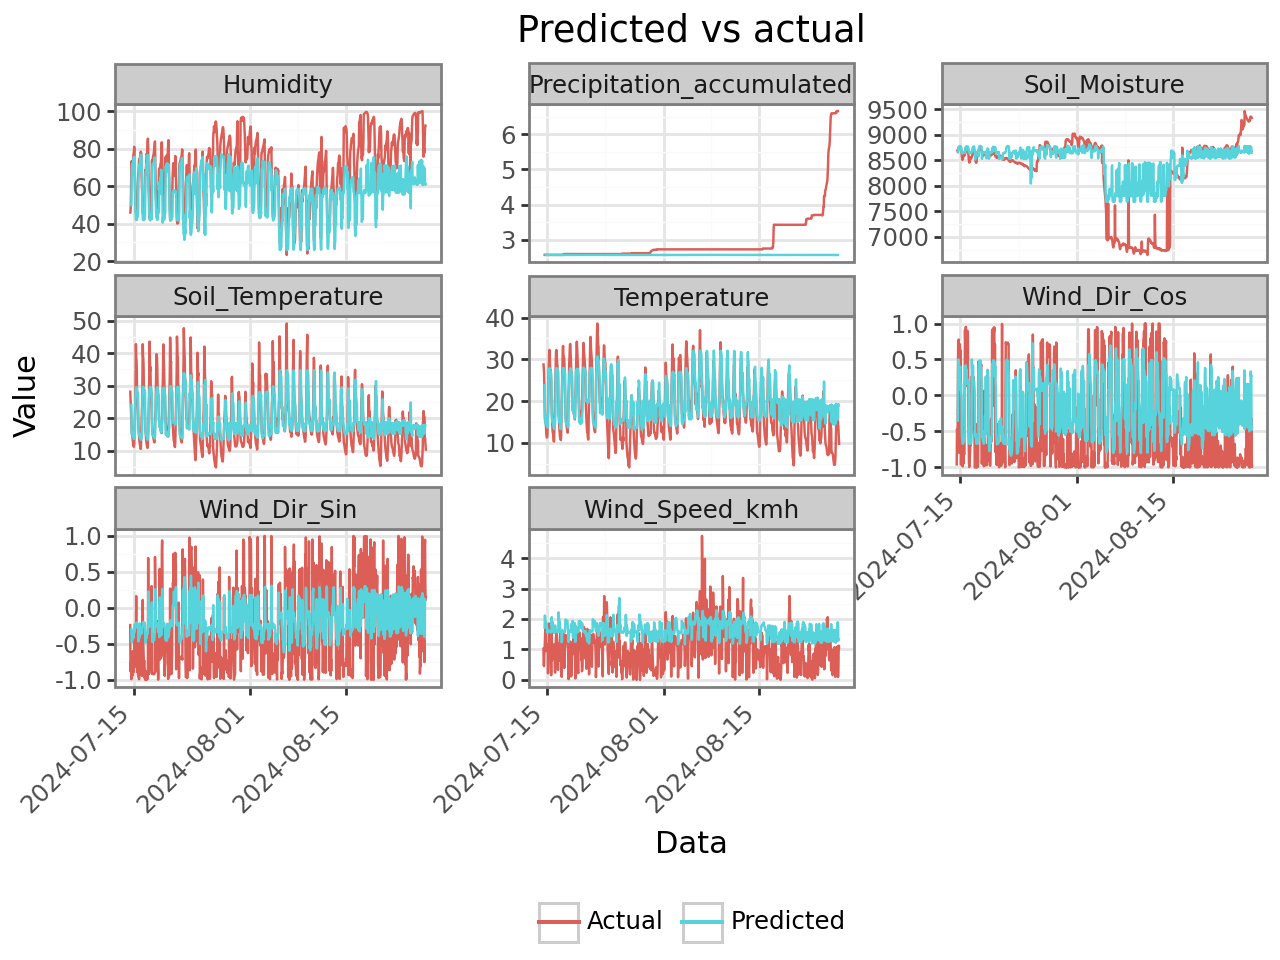

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [87]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

In [88]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

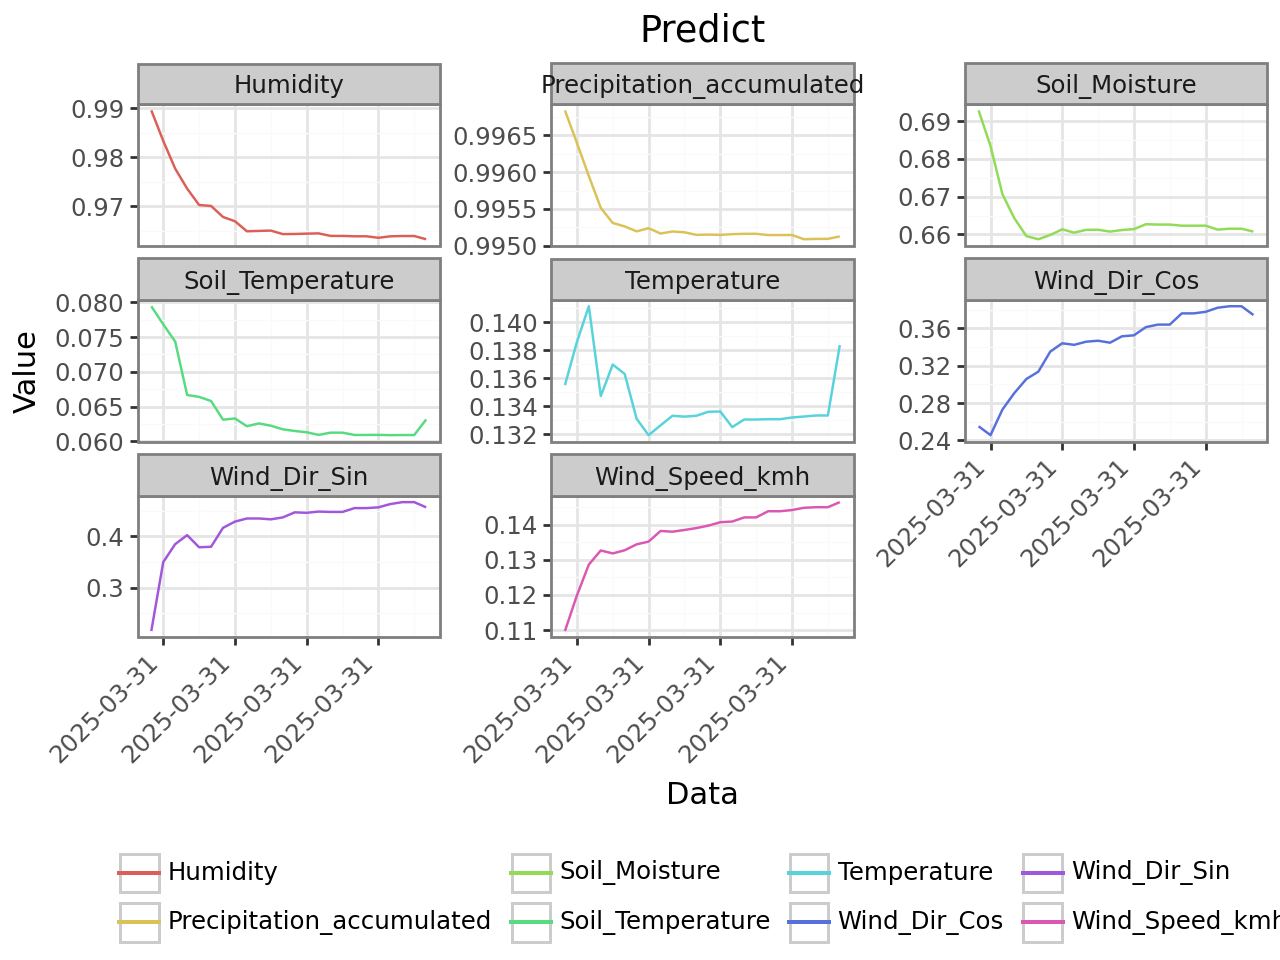

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_24.png


In [89]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Predict',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),

    )
)
plot.show()
plot.save('predict_24.png', width=12, height=10, dpi=300)

In [90]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)